In [1]:
import gc
import glob
import pandas
import numpy as np

import lightgbm as lgb
from datetime import datetime

from xgboost import XGBRanker
from lightgbm.sklearn import LGBMRanker

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

try: import cudf; GPU = True
except: GPU = False
    
from tqdm import tqdm
tqdm.pandas() # progress_map, apply ...

# • Полезные функции •
• _fillEvents(df, clone, value)_

    Заполнить все недостающие типы датафрейма.
    df - датафрейм
    clone - копировать имеющиеся типы (заполнять покупки кликами с картами)
    value - значение для заполнения, если clone = False
    
• _cloneEvents(df)_

    Установить датафрейм для всех типов. (Например, когда мы предсказали без учёта типов - добавляем столбец с type для всего df)

In [2]:
def groupType(x):
    res = list(set(x))
    return sum(res) if len(res) > 0 else -1
# -----------------------------------------------------------
def groupLen(x):
    return len(list(set(x)))
# -----------------------------------------------------------
def fillEvents(df, clone=True, value=[-1]):
    result = pd.DataFrame()
    _ = df[['session','type']].groupby(['session']).agg(ctype = ('type', groupType), count = ('type', groupLen))
    
    tmp = df[df['session'].isin(_[_['ctype'] == 0].index)].copy()
    if not clone: tmp['aid'] = tmp['aid'].apply(lambda x: value)
    tmp['type'] = 1
    result = pd.concat([result, tmp])
    tmp['type'] = 2
    result = pd.concat([result, tmp])

    tmp = df[df['session'].isin(_[_['ctype'] == 1].index)].copy().drop_duplicates(['session'])
    if not clone: tmp['aid'] = tmp['aid'].apply(lambda x: value)
    tmp['type'] = 2
    result = pd.concat([result, tmp])

    tmp = df[df['session'].isin(_[_['ctype'] == 2].index)].copy().drop_duplicates(['session'])
    if not clone: tmp['aid'] = tmp['aid'].apply(lambda x: value)
    tmp['type'] = 1
    result = pd.concat([result, tmp])
    
    tmp = df[df['session'].isin(_[(_['ctype'].isin([1, 2]))&(_['count'] == 1)].index)].copy()
    if not clone: tmp['aid'] = tmp['aid'].apply(lambda x: value)
    tmp['type'] = 0
    result = pd.concat([result, tmp])

    tmp = df[df['session'].isin(_[(_['ctype'] == 3)&(_['count'] == 2)].index)].copy()\
                .drop_duplicates(['session'])
    if not clone: tmp['aid'].apply(lambda x: [])
    tmp['type'] = 0
    result = pd.concat([result, tmp])

    return pd.concat([df, result])
# -----------------------------------------------------------
def cloneEvents(df):
    df['type'] = 0
    _ = df.copy()
    _['type'] = 1
    df = pd.concat([df, _])
    _['type'] = 2
    return pd.concat([df, _]).astype({'type': 'uint8'})

In [3]:
# ---------------------------------------------
def mergeMatrix(df, matrix):
    return pd.merge(df, matrix, how='left', on=['aid'])
# ---------------------------------------------
def prepareTrain(df=None, path=None, test=None, matrix=None, sample=1.0):
    if df is None: df = pd.read_parquet(path)
    df = df.sample(n=int(len(df)*sample))
    if test is not None: 
        test = pd.read_parquet(test)
        df = pd.concat([df, test])
    if matrix is not None:
        df['real_action'] = 1
        mdf = pd.read_parquet(matrix)
        mdf = mergeMatrix(mdf, df)[['session', 'type', 'labels']].dropna().astype({'session':'uint32', 'type':'uint8'})\
            .rename(columns={'labels':'aid'}).drop_duplicates(['session', 'type'])
        mdf['real_action'] = 0
        mdf['ts'] = 0
        mdf = mdf.explode('aid').astype({'aid':'uint32'})
        df = pd.concat([df, mdf])
        return df.astype({'real_action':'uint8','type':'uint8', 'aid':'uint32', 'ts':'uint32'})
    return df.astype({'type':'uint8', 'aid':'uint32', 'ts':'uint32'})
# ------------------------------------------------------    
def prepareTestLabels(df=None, path=None):
    if df is None: df = pd.read_parquet(path)
    df['gt'] = 1
    return df.astype({'session':'uint32', 'type':'uint8', 'aid':'uint32', 'gt':'float32'})
# ------------------------------------------------------    
def prepareLabels(df=None, path=None):
    if df is None: df = pd.read_parquet(path)
    df.rename(columns={'ground_truth':'aid'}, inplace=True)
    df['type'] = df['type'].map({'clicks':0, 'carts':1, 'orders':2})
    df['gt'] = 1
    df = df.explode('aid')
    return df.astype({'session':'uint32', 'type':'uint8', 'aid':'uint32', 'gt':'float32'})
# ------------------------------------------------------
def prepareTest(df=None, path=None, fill=False, clone=True):
    if df is None: df = pd.read_parquet(path)
    if fill: df = fillEvents(df, clone)
    df['real_action'] = 1
    return df.astype({'type':'uint8', 'real_action':'uint8'})
# ------------------------------------------------------
def loadTestLabels():
    df_true = pd.read_parquet('../input/otto-train-and-test-data-for-local-validation/test_labels.parquet')
    df_true['type'] = df_true['type'].map({'clicks':0, 'carts':1, 'orders':2})
    df_true = df_true.rename(columns={'ground_truth':'labels'})
    return df_true
# ------------------------------------------------------
def loadTestLabelsMy():
    df_true = pd.read_parquet('../input/local-validation-data/local_labels.parquet')
    df_true = df_true.groupby(['session', 'type']).agg(labels = ('aid', lambda x: list(dict.fromkeys(x)))).reset_index()
    return df_true
# ------------------------------------------------------
def loadHistory(path):
    df = pd.read_parquet(path)
    return df
# ------------------------------------------------------
def localMetrics(sub, df_true=None, load=loadTestLabels):
    # -- load ground truth
    if df_true is None: df_true = load()
    
    # -- calculate metrics
    test_labels = pd.merge(df_true, sub, how='left', on=['session', 'type'])
    test_labels.fillna('', inplace=True)

    test_labels['hits']     = test_labels.apply(lambda df: len(set(df['labels_x']).intersection(set(df['labels_y']))), axis=1)
    test_labels['gt_count'] = test_labels['labels_x'].str.len().clip(0,20)  
    
    recall_per_type = test_labels.groupby(['type'])['hits'].sum() / test_labels.groupby(['type'])['gt_count'].sum() 

    score = (recall_per_type * pd.Series({0: 0.10, 1: 0.30, 2: 0.60})).fillna(0)

    print(f"{score.sum():.3f} = {score[0]:.3f} + {score[1]:.3f} + {score[2]:.3f}")
    print('score:', score.sum())
    
    return test_labels
# ------------------------------------------------------
def setSubmission(df):
    df = df.copy()
    df['type'] = df['type'].map({0:'clicks', 1:'orders', 2:'carts'})
    df['session_type'] = df['session'].astype('str') + '_' + df['type']
    df['labels'] = df['labels'].fillna('').apply(lambda x: ' '.join(str(i) for i in x))
    return df.drop(['session', 'type'], axis=1)
# ------------------------------------------------------
def get_groups(df, column='gt'):
    return df.groupby('session')[column].count().sort_index().values
# ------------------------------------------------------

# • ФИЧИ •

In [4]:
# =========================== Basic =================================
def fSession(df):
    return 'session', df
# -----------------------------------------------------
def fAid(df):
    return 'aid', df
# -----------------------------------------------------
def fType(df):
    return 'type', df
# -----------------------------------------------------
def fts(df):
    return 'ts', df
# =========================== Prepare V1 (History) ========================
def session_length(df):
    # Длина сессии по количеству событий
    if df is not None:
        gr = df.groupby('session')['session'].count().astype('uint16')
        df.set_index('session', inplace=True)
        df['session_length'] = gr
        df.reset_index(inplace=True)
    return 'session_length', df
# -----------------------------------------------------
def action_num_reverse_chrono(df):
    if df is not None:
        df['action_num_reverse_chrono'] = df.groupby('session').cumcount(ascending=True).astype('uint16')
    return 'action_num_reverse_chrono', df
# -----------------------------------------------------
def log_recency_score(df):
    if df is not None:
        linear_interpolation = 0.1 + ((1-0.1) / (df['session_length']-1)) * (df['session_length']-df['action_num_reverse_chrono']-1)
        df['log_recency_score'] = (2 ** linear_interpolation - 1).fillna(1.0).astype('float32')
    return 'log_recency_score', df
# -----------------------------------------------------
def type_weighted_log_recency_score(df):
    if df is not None:
        df['type_weighted_log_recency_score'] = (df['log_recency_score'] / df['type'].map({0:1, 1:6, 2:3})).astype('float32')
    return 'type_weighted_log_recency_score', df

# =========================== Prepare V2 =================================
def item_item_count(df):
    if df is not None:
        gr = df.groupby('aid')['aid'].count().astype('uint16')
        df.set_index('aid', inplace=True)
        df['item_item_count'] = gr
        df.reset_index(inplace=True)
    return 'item_item_count', df
# -----------------------------------------------------
def item_user_count(df):
    if df is not None:
        gr = df.groupby('aid')['session'].nunique().astype('uint16')
        df.set_index('aid', inplace=True)
        df['item_user_count'] = gr
        df.reset_index(inplace=True)
    return 'item_user_count', df
# -----------------------------------------------------
def item_buy_ratio(df):
    if df is not None:
        gr = df.groupby('aid')['type'].mean().astype('float32')
        df.set_index('aid', inplace=True)
        df['item_buy_ratio'] = gr
        df.reset_index(inplace=True)
    return 'item_buy_ratio', df
# -----------------------------------------------------
def user_user_count(df):
    if df is not None:
        gr = df.groupby('session')['session'].count().astype('uint16')
        df.set_index('session', inplace=True)
        df['user_user_count'] = gr
        df.reset_index(inplace=True)
    return 'user_user_count', df
# -----------------------------------------------------
def user_item_count(df):
    if df is not None:
        gr = df.groupby('session')['aid'].nunique().astype('uint16')
        df.set_index('session', inplace=True)
        df['user_item_count'] = gr
        df.reset_index(inplace=True)
    return 'user_item_count', df
# -----------------------------------------------------
def user_buy_ratio(df):
    if df is not None:
        gr = df.groupby('session')['type'].mean().astype('float32')
        df.set_index('session', inplace=True)
        df['user_buy_ratio'] = gr
        df.reset_index(inplace=True)
    return 'user_buy_ratio', df

# =========================== Prepare V3 =================================
def bought_in_session(df):
    if df is not None:
        if 'bought_in_session' in df.columns: df.drop('bought_in_session', axis=1, inplace=True)
        _ = df[df['type'] == 2][['session', 'aid']].drop_duplicates()
        _['bought_in_session'] = 1
        df = df.merge(_, how='left', on=['session', 'aid']).fillna(0).astype({'bought_in_session':'uint8'})
    return 'bought_in_session', df

In [5]:
# =========================== Prepare V3 =================================
def aid_clicked_count(df):
    if df is not None:
        gr = df.loc[df['type']==0].groupby('aid')['aid'].count()
        df.set_index('aid', inplace=True)
        df['aid_clicked_count'] = gr
        df.reset_index(inplace=True)
        df['aid_clicked_count'].fillna(0, inplace=True)
        df['aid_clicked_count'] = df['aid_clicked_count'].astype('uint16')
    return 'aid_clicked_count', df
# -----------------------------------------------------
def aid_carted_count(df):
    if df is not None:
        gr = df.loc[df['type']==1].groupby('aid')['aid'].count()
        df.set_index('aid', inplace=True)
        df['aid_carted_count'] = gr
        df.reset_index(inplace=True)
        df['aid_carted_count'].fillna(0, inplace=True)
        df['aid_carted_count'] = df['aid_carted_count'].astype('uint16')
    return 'aid_carted_count', df
# -----------------------------------------------------
def aid_ordered_count(df):
    if df is not None:
        gr = df.loc[df['type']==2].groupby('aid')['aid'].count()
        df.set_index('aid', inplace=True)
        df['aid_ordered_count'] = gr
        df.reset_index(inplace=True)
        df['aid_ordered_count'].fillna(0, inplace=True)
        df['aid_ordered_count'] = df['aid_ordered_count'].astype('uint16')
    return 'aid_ordered_count', df
# -----------------------------------------------------
def session_length_unique(df):
    if df is not None:
        tmp = df.drop_duplicates(['session', 'aid'])
        gr = tmp.groupby('session')['session'].count().astype('uint16')
        df.set_index('session', inplace=True)
        df['session_length_unique'] = gr
        df.reset_index(inplace=True)
    return 'session_length_unique', df
# -----------------------------------------------------
def sec_to_session_end(df):
    if df is not None:
        gr = df.groupby('session')['ts'].max()
        df.set_index('session', inplace=True)
        df['ts_max'] = gr
        df['sec_to_session_end'] = df['ts_max'] - df['ts']
        df.drop('ts_max', axis=1, inplace=True)
        df.reset_index(inplace=True)
        df['sec_to_session_end'] = df['sec_to_session_end'].astype('uint32')
    return 'sec_to_session_end', df
# -----------------------------------------------------
def sec_since_session_start(df):
    if df is not None:
        gr = df.groupby('session')['ts'].min()
        df.set_index('session', inplace=True)
        df['ts_min'] = gr
        df['sec_since_session_start'] = df['ts'] - df['ts_min']
        df.drop('ts_min', axis=1, inplace=True)
        df.reset_index(inplace=True)
        df['sec_since_session_start'] = df['sec_since_session_start'].astype('uint32')
    return 'sec_since_session_start', df


# =========================== Prepare V4 =================================
def this_aid_clicked_count(df):
    if df is not None:
        if 'this_aid_clicked_count' in df.columns: df.drop('this_aid_clicked_count', axis=1, inplace=True)
        tmp = df.loc[df['type']==0].groupby(['session', 'aid', 'type']).agg(this_aid_clicked_count=('ts', 'count')).reset_index()
        df = df.merge(tmp, how='left', on=['session', 'aid', 'type'])
        df['this_aid_clicked_count'].fillna(0, inplace=True)
        df = df.astype({'this_aid_clicked_count':'uint8'})
    return 'this_aid_clicked_count', df
# -----------------------------------------------------
def this_aid_carted_count(df):
    if df is not None:
        if 'this_aid_carted_count' in df.columns: df.drop('this_aid_carted_count', axis=1, inplace=True)
        tmp = df.loc[df['type']==0].groupby(['session', 'aid', 'type']).agg(this_aid_carted_count=('ts', 'count')).reset_index()
        df = df.merge(tmp, how='left', on=['session', 'aid', 'type'])
        df['this_aid_carted_count'].fillna(0, inplace=True)
        df = df.astype({'this_aid_carted_count':'uint8'})
    return 'this_aid_carted_count', df
# -----------------------------------------------------
def this_aid_ordered_count(df):
    if df is not None:
        if 'this_aid_ordered_count' in df.columns: df.drop('this_aid_ordered_count', axis=1, inplace=True)
        tmp = df.loc[df['type']==0].groupby(['session', 'aid', 'type']).agg(this_aid_ordered_count=('ts', 'count')).reset_index()
        df = df.merge(tmp, how='left', on=['session', 'aid', 'type'])
        df['this_aid_ordered_count'].fillna(0, inplace=True)
        df = df.astype({'this_aid_ordered_count':'uint8'})
    return 'this_aid_ordered_count', df
# -----------------------------------------------------
def onehot_clicks(df):
    if df is not None:
        df['onehot_clicks'] = 0
        df.loc[df['type']==0, 'onehot_clicks'] = 1
    return 'onehot_clicks', df
# -----------------------------------------------------
def onehot_carts(df):
    if df is not None:
        df['onehot_carts'] = 0
        df.loc[df['type']==1, 'onehot_carts'] = 1
    return 'onehot_carts', df
# -----------------------------------------------------
def onehot_orders(df):
    if df is not None:
        df['onehot_orders'] = 0
        df.loc[df['type']==2, 'onehot_orders'] = 1
    return 'onehot_orders', df
# -----------------------------------------------------

In [6]:
def no_clicks(df):
    if df is not None:
        df = df.loc[df['type']!=0]
    return None, df
# -----------------------------------------------------
def no_carts(df):
    if df is not None:
        df = df.loc[df['type']!=1]
    return None, df
# -----------------------------------------------------
def no_orders(df):
    if df is not None:
        df = df.loc[df['type']!=2]
    return None, df
# -----------------------------------------------------
def only_clicks(df):
    if df is not None:
        df = df.loc[df['type']==0]
    return None, df
# -----------------------------------------------------
def only_carts(df):
    if df is not None:
        df = df.loc[df['type']==1]
    return None, df
# -----------------------------------------------------
def only_orders(df):
    if df is not None:
        df = df.loc[df['type']==2]
    return None, df
# =========================== Prepare V4 =================================
def clicks_user_counter(df):
    if df is not None:
        if 'clicks_user_counter' in df.columns: df.drop('clicks_user_counter', axis=1, inplace=True)
        tmp = df[df['type']==0].groupby(['aid']).agg(clicks_user_counter=('session', 'nunique'))
        df = df.merge(tmp, how='left', right_index=True, left_on='aid')
        df['clicks_user_counter'].fillna(0, inplace=True)
        df = df.astype({'clicks_user_counter':'uint16'})
    return 'clicks_user_counter', df
# -----------------------------------------------------
def carts_user_counter(df):
    if df is not None:
        if 'carts_user_counter' in df.columns: df.drop('carts_user_counter', axis=1, inplace=True)
        tmp = df[df['type']==1].groupby(['aid']).agg(carts_user_counter=('session', 'nunique'))
        df = df.merge(tmp, how='left', right_index=True, left_on='aid')
        df['carts_user_counter'].fillna(0, inplace=True)
        df = df.astype({'carts_user_counter':'uint16'})
    return 'carts_user_counter', df
# -----------------------------------------------------
def orders_user_counter(df):
    if df is not None:
        if 'orders_user_counter' in df.columns: df.drop('orders_user_counter', axis=1, inplace=True)
        tmp = df[df['type']==2].groupby(['aid']).agg(orders_user_counter=('session', 'nunique'))
        df = df.merge(tmp, how='left', right_index=True, left_on='aid')
        df['orders_user_counter'].fillna(0, inplace=True)
        df = df.astype({'orders_user_counter':'uint16'})
    return 'orders_user_counter', df
# -----------------------------------------------------
def clicks_timed_global_counter(df):
    if df is not None:
        df['wgt'] = df.groupby('session').cumcount() + 1
        df['wgt'] = df['wgt'] / df['wgt'].max()
        gr = df[df['type']==0].groupby(['aid'])['wgt'].sum()
        df.set_index('aid', inplace=True)
        df['clicks_timed_global_counter'] = gr
        df.drop('wgt', axis=1, inplace=True)
        df.reset_index(inplace=True)
        df['clicks_timed_global_counter'].fillna(0, inplace=True)
        df['clicks_timed_global_counter'] = df['clicks_timed_global_counter'].astype('float32')
    return 'clicks_timed_global_counter', df
# -----------------------------------------------------
def carts_timed_global_counter(df):
    if df is not None:
        df['wgt'] = df.groupby('session').cumcount() + 1
        df['wgt'] = df['wgt'] / df['wgt'].max()
        gr = df[df['type']==0].groupby(['aid'])['wgt'].sum()
        df.set_index('aid', inplace=True)
        df['carts_timed_global_counter'] = gr
        df.drop('wgt', axis=1, inplace=True)
        df.reset_index(inplace=True)
        df['carts_timed_global_counter'].fillna(0, inplace=True)
        df['carts_timed_global_counter'] = df['carts_timed_global_counter'].astype('float32')
    return 'carts_timed_global_counter', df
# -----------------------------------------------------
def orders_timed_global_counter(df):
    if df is not None:
        df['wgt'] = df.groupby('session').cumcount() + 1
        df['wgt'] = df['wgt'] / df['wgt'].max()
        gr = df[df['type']==0].groupby(['aid'])['wgt'].sum()
        df.set_index('aid', inplace=True)
        df['orders_timed_global_counter'] = gr
        df.drop('wgt', axis=1, inplace=True)
        df.reset_index(inplace=True)
        df['orders_timed_global_counter'].fillna(0, inplace=True)
        df['orders_timed_global_counter'] = df['orders_timed_global_counter'].astype('float32')
    return 'orders_timed_global_counter', df
def user_ratio(df):
    # соотношение кликов/покупок/корзин пользователя (type, mean)
    if df is not None:
        gr = df.groupby(['session', 'type'])['type'].count().rename('count').reset_index()
        df = df.merge(gr[gr['type'] == 0].rename(columns={'count':'clicks'})[['session', 'clicks']], how='left', on=['session'])
        df = df.merge(gr[gr['type'] == 1].rename(columns={'count':'carts'})[['session', 'carts']], how='left', on=['session'])
        df = df.merge(gr[gr['type'] == 2].rename(columns={'count':'orders'})[['session', 'orders']], how='left', on=['session'])
        df['user_carts_clicks_ratio'] = df['carts'] / df['clicks'].astype('float32')
        df['user_orders_carts_ratio'] = df['orders'] / df['carts'].astype('float32')
        df['user_orders_clicks_ratio'] = df['orders'] / df['clicks'].astype('float32')
        df.drop(['clicks', 'carts', 'orders'], axis=1, inplace=True)
        df.fillna(0, inplace=True)
    return ['user_carts_clicks_ratio', 'user_orders_carts_ratio', 'user_orders_clicks_ratio'], df

#	covisit_clicks_candidate_num		0.24848206202059703
#	covisit_buys_candidate_num 			0.009287900880354305
#	aid_interacted_with_count 			0.004570131040186471
#	relative_position_in_session 		0.00021918611998695227
#	popularity_0 						0.0
#	popularity_1 						0.0
#	popularity_2 						0.0
# -----------------------------------------------------

# • Пайплайны •

In [7]:
def callPipeline(df, pipeline):
    ft = []
    if type(pipeline) is list:
        for func in pipeline:
            result, df = func(df)
            if result is not None:
                ft.extend(result if type(result) is list else [result])
        return ft, df
    else: return pipeline(df)
# -----------------------------------------------------
def V1(df):
    ft = []
    for func in [session_length, action_num_reverse_chrono]:
        result, df = func(df)
        if result is not None: ft.append(result)
    return ft, df
# -----------------------------------------------------
def V2(df):
    ft = []
    for func in [item_item_count, item_user_count, item_buy_ratio, user_item_count, user_buy_ratio, bought_in_session]:
        result, df = func(df)
        if result is not None: ft.append(result)
    return ft, df
# -----------------------------------------------------
def V3(df):
    ft = []
    for func in [aid_clicked_count, aid_carted_count, aid_ordered_count, sec_to_session_end, sec_since_session_start]:
        result, df = func(df)
        if result is not None: ft.append(result)
    return ft, df
# -----------------------------------------------------
def V4(df):
    ft = []
    for func in [this_aid_clicked_count, this_aid_carted_count, this_aid_ordered_count, onehot_clicks, onehot_carts, onehot_orders]:
        result, df = func(df)
        if result is not None: ft.append(result)
    return ft, df
# -----------------------------------------------------
def V5(df):
    ft = []
    for func in [clicks_user_counter, carts_user_counter, orders_user_counter, clicks_timed_global_counter, carts_timed_global_counter, orders_timed_global_counter]:
        result, df = func(df)
        if result is not None: ft.append(result)
    return ft, df

# • Конфиг •

In [14]:
# ==================================================================
# ----- Конфигурация сессии для экспериментов-----------------------
# ==================================================================
LOCAL = True  # Тип метрики. True - локально, False - Kaggle
SAVE  = True # Сохранять ли файлы. Нужно при сохранении датасета
SHOW  = True # Выводить ли таблицы в процессе
GPU   = False # Использовать GPU
FAST  = LOCAL if LOCAL == False else False # быстрый режим обучения модели (устанавливаем малое количество итераций и lr)
# -----------------------------------------------------------------
params = {
    'train': '../input/otto-train-and-test-data-for-local-validation/train.parquet',
    'chunks': 10,
    'sample': 0.05,
    'test_labels': '../input/otto-train-and-test-data-for-local-validation/test_labels.parquet',
    'use_test_labels': False,
    'load_features': False, # если меняем датасет или пайплайн, то ставим False, чтобы обновить файлы
    'load_test_features': False, # если меняем пайплайн, то ставим False, чтобы обновить файлы теста
    'force_ranking': False, # разные модели для предсказания кликов, корзин и покупок
    'matrix': None, #'/kaggle/input/prepaired-files/covisit_matrix.parquet',
    'test': None, #'/'
    'testLabels': loadTestLabels,
    'model': LGBMRanker, #XGBRanker,
    'metric': 'ndcg',
    'params': {
        'objective':'lambdarank', # LightGBMRanker
        'boosting_type':"dart",
        'n_estimators': 1,
        'learning_rate': 0.2,
        #'eval_metric': 'ndcg', # XGBRanker
        #'objective':'rank:pairwise', # XGBRanker
    },
    'pipeline': [V1, V2, V3, V4, V5, user_ratio],
    'remove_features': [],
    'base_features': [], # 'real_action'
    'target': 'gt',
    'withType': False, # учитывать ли тип при предсказании
    'fillTest': False, # заполнять ли пропущенные события в test 
    'drop_byes_from_labels': False, # удалить из проверочных данных покупки
    'plotInfo': {
        'cols': 3,
        'labels': 6
    }
}
# ----------------------------------------------------
if GPU: import cudf
pd = cudf if GPU else pandas
print('We will use RAPIDS version',cudf.__version__) if GPU else print('We will use CPU', '...')

We will use CPU ...


# • Подготовка фич •

In [15]:
%%time
# ~ 40s
from math import ceil
if not params['load_features']:
    train = prepareTrain(path=params["train"], matrix=params['matrix'], test=params['test'], sample=params['sample'])
    start = train['session'].min()
    end = train['session'].max()
    ln = ceil((end - start) / params['chunks'])
    if SHOW: print(f"min: {start}", f'max: {end}', f'size: {ln}')
    if SHOW: display(train.head(4))
    for i in range(0, params['chunks']):
        s = start + i*ln
        e = min(start + (i+1)*ln, end + 1)
        print('\r', f'chunk {i+1} of {params["chunks"]} ({s} to {e-1})')#, end = '   ')
        train[(train['session']>=s)&(train['session']<e)].to_parquet(f'train_{i}.parquet', index=False)
    del train; gc.collect()

min: 0 max: 11098526 size: 1109853


,session,aid,ts,type
139319314,8093796,352623,1660457451,0
27754947,824264,234367,1660303206,0
105486283,5070035,176643,1659878245,0
77866766,3221114,649941,1660469627,0


 chunk 1 of 10 (0 to 1109852)
 chunk 2 of 10 (1109853 to 2219705)
 chunk 3 of 10 (2219706 to 3329558)
 chunk 4 of 10 (3329559 to 4439411)
 chunk 5 of 10 (4439412 to 5549264)
 chunk 6 of 10 (5549265 to 6659117)
 chunk 7 of 10 (6659118 to 7768970)
 chunk 8 of 10 (7768971 to 8878823)
 chunk 9 of 10 (8878824 to 9988676)
 chunk 10 of 10 (9988677 to 11098526)
CPU times: user 22.2 s, sys: 10.4 s, total: 32.6 s
Wall time: 35.5 s


In [16]:
%%time
# ~ V1, V2 - 20s, V3 - 11m 10s
if not params['load_features']:
    for i in range(0, params['chunks']):
        train = pd.read_parquet(f'train_{i}.parquet')
        s, e = train['session'].min(), train['session'].max()
        print('\r', f'chunk {i+1} of {params["chunks"]} ({s} to {e})')#, end = '   ')
        __, train = callPipeline(train, params['pipeline'])
        train.to_parquet(f'train_{i}f.parquet', index=False)
    gc.collect()

 chunk 1 of 10 (0 to 1109852)
 chunk 2 of 10 (1109853 to 2219704)
 chunk 3 of 10 (2219706 to 3329557)
 chunk 4 of 10 (3329560 to 4439408)
 chunk 5 of 10 (4439414 to 5549260)
 chunk 6 of 10 (5549271 to 6659117)
 chunk 7 of 10 (6659119 to 7768968)
 chunk 8 of 10 (7768971 to 8878823)
 chunk 9 of 10 (8878825 to 9988675)
 chunk 10 of 10 (9988685 to 11098526)
CPU times: user 2min 28s, sys: 5.87 s, total: 2min 33s
Wall time: 2min 33s


In [17]:
#if not params['load_features']:
#    if params['drop_byes_from_labels']:
#        _ = train[(train['type'] == 2)&(train['gt'] == 0)][['session', 'aid', 'type']]
#        _['gt'] = 1
#        _['in_sess'] = 1
#        train = pd.merge(train, _, how='left', on=['session', 'aid', 'type', 'gt'])
#        train.loc[train['in_sess'] == 1, 'gt'] = 0
#        train.drop('in_sess', axis=1, inplace=True)
#    if SHOW: display(train.head(4))

# • Обучение модели •

In [18]:
ranker = []
for i in range(0, 3 if params['force_ranking'] else 1):
    ranker.append(params['model'](**params['params'], importance_type='gain', force_col_wise=True))
ranker

[LGBMRanker(boosting_type='dart', force_col_wise=True, importance_type='gain',
            learning_rate=0.2, n_estimators=1, objective='lambdarank')]

In [19]:
features, __ = callPipeline(None, params['pipeline'])
if SHOW: print(features)

['session_length', 'action_num_reverse_chrono', 'item_item_count', 'item_user_count', 'item_buy_ratio', 'user_item_count', 'user_buy_ratio', 'bought_in_session', 'aid_clicked_count', 'aid_carted_count', 'aid_ordered_count', 'sec_to_session_end', 'sec_since_session_start', 'this_aid_clicked_count', 'this_aid_carted_count', 'this_aid_ordered_count', 'onehot_clicks', 'onehot_carts', 'onehot_orders', 'clicks_user_counter', 'carts_user_counter', 'orders_user_counter', 'clicks_timed_global_counter', 'carts_timed_global_counter', 'orders_timed_global_counter', 'user_carts_clicks_ratio', 'user_orders_carts_ratio', 'user_orders_clicks_ratio']


In [20]:
def loadLabelsForTest(df, matrix=False):
    test = prepareLabels(path=params["test_labels"]).drop_duplicates(['session', 'aid', 'type'])
    df = df.merge(test, on=['session', 'aid', 'type'], how='left')
    df['gt'] = df['gt'].astype('float32')
    df.fillna(0, inplace=True)
    return df

In [21]:
def splitTrainToLabels(df, t=None, p=0.9, matrix=False):
    if t is not None:
        train_cutoff = df['ts'].max() - t
        train = df[df['ts'] <= train_cutoff]
        test = df[df['ts'] > train_cutoff].copy()
    else:
        group = df.groupby('session')['ts']
        train_cutoff = (group.min() + (group.max() - group.min())*0.8).rename('ts_agg').astype('uint32')
        train = pd.merge(df, train_cutoff, how='left', on='session')
        
        test = train[train['ts'] > train['ts_agg']]
        train = train[train['ts'] <= train['ts_agg']].drop('ts_agg', axis=1)
    test['gt'] = 1
    train = train.merge(test[['session', 'aid', 'type', 'gt']], how='left', on=['session', 'aid', 'type'])
    train['gt'].fillna(0, inplace=True)
    return train.astype({'gt':'float32'})

In [22]:
%%time
# ~ 20s
errors = []
for i in range(0, params['chunks']):
    train = pd.read_parquet(f'train_{i}f.parquet')
    s, e = train['session'].min(), train['session'].max()
    print('\r', f'chunk {i+1} of {params["chunks"]} ({s} to {e})')#, end = '   ')
    if 'gt' in train.columns: train.drop(['gt'], axis=1, inplace=True)
    train = train.drop_duplicates(features)
    train = loadLabelsForTest(train) if params['use_test_labels'] else splitTrainToLabels(train)
    #if SHOW: display(train.head(2))
    for j, item in enumerate(ranker):
        if params['force_ranking']:
            train.loc[train['type']!=j, 'gt'] = 0
        try:
            item = item.fit(
                train[features], train[params['target']],
                group=get_groups(train),
            )
        except Exception as ex:
            print('exception:', ex, 'chunk', i, 'ranker', j)
            errors.append({'chunk': i, 'ranker': j})

 chunk 1 of 10 (0 to 1109852)
 chunk 2 of 10 (1109853 to 2219704)
 chunk 3 of 10 (2219706 to 3329557)
 chunk 4 of 10 (3329560 to 4439408)
 chunk 5 of 10 (4439414 to 5549260)
 chunk 6 of 10 (5549271 to 6659117)
 chunk 7 of 10 (6659119 to 7768968)
 chunk 8 of 10 (7768971 to 8878823)
 chunk 9 of 10 (8878825 to 9988675)
 chunk 10 of 10 (9988685 to 11098526)
CPU times: user 42.3 s, sys: 3.7 s, total: 46 s
Wall time: 28.5 s


In [23]:
#while len(errors) > 0:
#    for item in errors:
#        train = pd.read_parquet(f'train_{i}f.parquet')      

In [24]:
for i, item in enumerate(ranker):
    item.booster_.save_model(f'model_{i}.lgb', num_iteration=None, start_iteration=0, importance_type='gain')

# • Результаты обучения •

In [25]:
mln = max([len(i) for i in features])
for i, item in enumerate(ranker):
    print(f'ranker_{i}')
    for i in item.feature_importances_.argsort()[::-1]:
        ln = (mln + 2) - len(features[i])
        print(features[i], ' ',  '-'*ln, '>', round(item.feature_importances_[i]/item.feature_importances_.sum(), 6))

ranker_0
this_aid_clicked_count   ------- > 0.924725
aid_carted_count   ------------- > 0.019775
carts_user_counter   ----------- > 0.013049
user_buy_ratio   --------------- > 0.012327
user_item_count   -------------- > 0.009292
sec_to_session_end   ----------- > 0.004597
clicks_timed_global_counter   -- > 0.003289
sec_since_session_start   ------ > 0.002284
user_orders_clicks_ratio   ----- > 0.002221
aid_ordered_count   ------------ > 0.002187
orders_user_counter   ---------- > 0.002132
session_length   --------------- > 0.001572
bought_in_session   ------------ > 0.00104
aid_clicked_count   ------------ > 0.000846
user_carts_clicks_ratio   ------ > 0.000663
action_num_reverse_chrono   ---- > 0.0
item_item_count   -------------- > 0.0
item_user_count   -------------- > 0.0
item_buy_ratio   --------------- > 0.0
orders_timed_global_counter   -- > 0.0
onehot_orders   ---------------- > 0.0
onehot_carts   ----------------- > 0.0
clicks_user_counter   ---------- > 0.0
user_orders_carts_ra

ranker_0


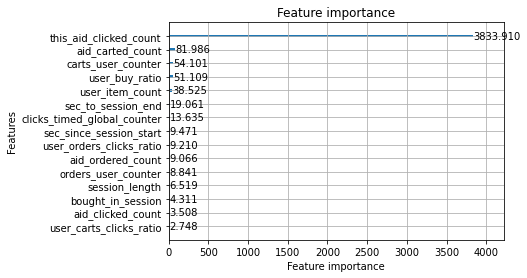

In [26]:
from lightgbm import plot_importance
for i, item in enumerate(ranker):
    print(f'ranker_{i}')
    if params['model'] == LGBMRanker: plot_importance(item)

ranker_0


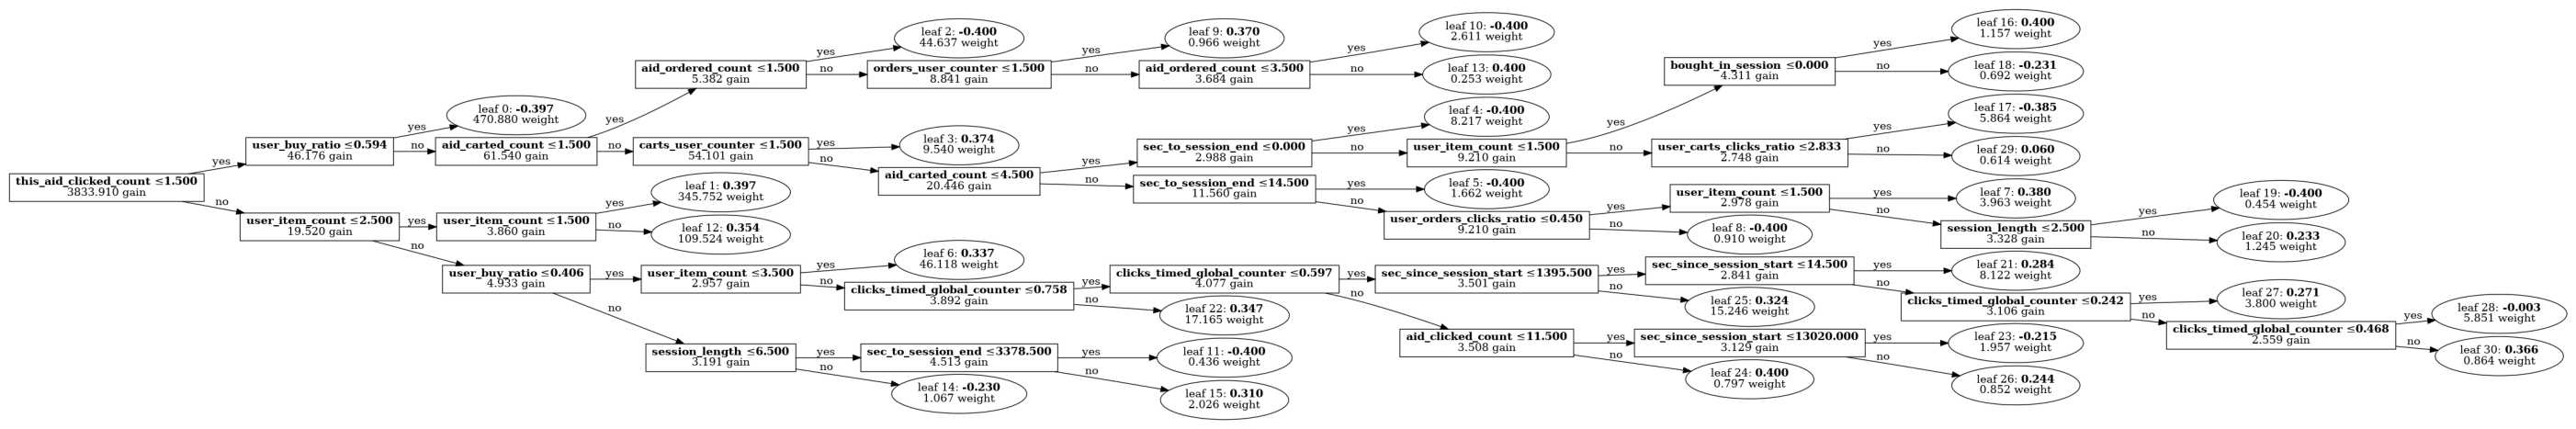

In [27]:
from lightgbm import plot_tree
for i, item in enumerate(ranker):
    print(f'ranker_{i}')
    if params['model'] == LGBMRanker: plot_tree(item, figsize=(50, 50), show_info=['split_gain', 'leaf_weight'])

In [28]:
from lightgbm import plot_metric
import matplotlib.pyplot as plt

if params['model'] == LGBMRanker: 
    i, j = 0, 0
    r = round(params['plotInfo']['labels'] / params['plotInfo']['cols'])
    #_, ax = plt.subplots(r, params['plotInfo']['cols'], figsize=(64/params['plotInfo']['cols'], 5*r))
    for l in range(0, params['plotInfo']['labels']):
        #qx = ax[j] if r == 1 else ax[i, j]
        #plot_metric(ranker, xlabel='Iterations', ylabel=f'{params["metric"]}@{l}', ax=qx)
        j = j + 1
        i = i + 1 if j == params['plotInfo']['cols'] else i
        j = 0 if j == params['plotInfo']['cols'] else j

# • Предсказание •

In [29]:
%%time
# ~CategoricalIndex V1, V2 - 1s, V3 - 12m
if not params['load_test_features']:
    path = 'otto-train-and-test-data-for-local-validation' if LOCAL else 'otto-full-optimized-memory-footprint'

    test = prepareTest(path=f'../input/{path}/test.parquet', fill=params['fillTest'])
    pipeline = params['pipeline']
    for i in [no_clicks, no_carts, no_orders, only_clicks, only_carts, only_orders]:
        if i in pipeline: pipeline.remove(i)
    features, test = callPipeline(test, pipeline)
    features += params['base_features']
    for i in params['remove_features']:
        if i in features: features.remove(i)
    test.to_parquet('test_features.parquet', index=False)
    if SHOW: display(test.sort_values(['aid']).head(4))

,aid,session,ts,type,real_action,session_length,action_num_reverse_chrono,item_item_count,item_user_count,item_buy_ratio,...,onehot_orders,clicks_user_counter,carts_user_counter,orders_user_counter,clicks_timed_global_counter,carts_timed_global_counter,orders_timed_global_counter,user_carts_clicks_ratio,user_orders_carts_ratio,user_orders_clicks_ratio
7290120,0,12789028,1661709325,0,1,61,35,5,4,0.0,...,0,4,0,0,0.313978,0.313978,0.313978,0.134615,0.285714,0.038462
2641442,0,11678917,1661313173,0,1,73,30,5,4,0.0,...,0,4,0,0,0.313978,0.313978,0.313978,0.013889,0.000000,0.000000
2641427,0,11678917,1661312256,0,1,73,15,5,4,0.0,...,0,4,0,0,0.313978,0.313978,0.313978,0.013889,0.000000,0.000000
4276263,0,12064842,1661626966,0,1,21,17,5,4,0.0,...,0,4,0,0,0.313978,0.313978,0.313978,0.357143,0.400000,0.142857


CPU times: user 1min 41s, sys: 22.1 s, total: 2min 3s
Wall time: 2min 4s


In [30]:
test = pd.read_parquet('test_features.parquet')
if SHOW: display(test.sort_values(['aid']).head(4))

,aid,session,ts,type,real_action,session_length,action_num_reverse_chrono,item_item_count,item_user_count,item_buy_ratio,...,onehot_orders,clicks_user_counter,carts_user_counter,orders_user_counter,clicks_timed_global_counter,carts_timed_global_counter,orders_timed_global_counter,user_carts_clicks_ratio,user_orders_carts_ratio,user_orders_clicks_ratio
7290120,0,12789028,1661709325,0,1,61,35,5,4,0.0,...,0,4,0,0,0.313978,0.313978,0.313978,0.134615,0.285714,0.038462
2641442,0,11678917,1661313173,0,1,73,30,5,4,0.0,...,0,4,0,0,0.313978,0.313978,0.313978,0.013889,0.000000,0.000000
2641427,0,11678917,1661312256,0,1,73,15,5,4,0.0,...,0,4,0,0,0.313978,0.313978,0.313978,0.013889,0.000000,0.000000
4276263,0,12064842,1661626966,0,1,21,17,5,4,0.0,...,0,4,0,0,0.313978,0.313978,0.313978,0.357143,0.400000,0.142857


In [31]:
%%time
# ~ 2s
for i, item in enumerate(ranker):
    scores = item.predict(test[features])
    test[f'score_{i}'] = scores
if SHOW: display(test)

,aid,session,ts,type,real_action,session_length,action_num_reverse_chrono,item_item_count,item_user_count,item_buy_ratio,...,clicks_user_counter,carts_user_counter,orders_user_counter,clicks_timed_global_counter,carts_timed_global_counter,orders_timed_global_counter,user_carts_clicks_ratio,user_orders_carts_ratio,user_orders_clicks_ratio,score_0
0,11830,11098528,1661119200,0,1,1,0,1230,849,0.129268,...,843,119,15,18.774193,18.774193,18.774193,0.0,0.0,0.0,-0.397351
1,1105029,11098529,1661119200,0,1,1,0,5,5,0.000000,...,5,0,0,0.051613,0.051613,0.051613,0.0,0.0,0.0,-0.397351
2,264500,11098530,1661119200,0,1,6,0,142,99,0.014085,...,99,2,0,5.322581,5.322581,5.322581,0.2,0.0,0.0,0.354348
3,264500,11098530,1661119288,0,1,6,1,142,99,0.014085,...,99,2,0,5.322581,5.322581,5.322581,0.2,0.0,0.0,0.354348
4,409236,11098530,1661119369,0,1,6,2,515,332,0.095146,...,331,29,4,6.079570,6.079570,6.079570,0.2,0.0,0.0,0.354348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7683572,33035,12899774,1661723968,0,1,1,0,171,146,0.000000,...,146,0,0,2.154839,2.154839,2.154839,0.0,0.0,0.0,-0.397351
7683573,1743151,12899775,1661723970,0,1,1,0,532,364,0.054511,...,364,20,1,10.270967,10.270967,10.270967,0.0,0.0,0.0,-0.397351
7683574,548599,12899776,1661723972,0,1,1,0,16,13,0.062500,...,13,1,0,0.329032,0.329032,0.329032,0.0,0.0,0.0,-0.397351
7683575,384045,12899777,1661723976,0,1,1,0,133,94,0.030075,...,94,4,0,2.148387,2.148387,2.148387,0.0,0.0,0.0,-0.397351


CPU times: user 5.19 s, sys: 1.49 s, total: 6.68 s
Wall time: 4.08 s


In [32]:
%%time
# ~ 20s
columns = ['session', 'type'] if params['withType'] else ['session']
get_cols = ['session', 'aid', 'type'] if params['withType'] else ['session', 'aid']

preds = pd.DataFrame()
order = [1, 0, 2] if params['force_ranking'] else [0]
for i in order:
    tmp = test.sort_values(by=['session', f'score_{i}'], ascending=False)[get_cols].reset_index(drop=True)
    preds = pd.concat([preds, tmp])
tmp = preds.groupby(columns).head(20).groupby(columns).agg(labels=('aid', lambda x: list(set(x)))).reset_index(drop=False)

preds.drop('aid', axis=1, inplace=True)
preds.drop_duplicates(columns,inplace=True)
preds = pd.merge(preds, tmp, how='left', on=columns)

if params['withType']: preds = fillEvents(preds, clone=True)
elif not params['withType']: preds = cloneEvents(preds)

if SAVE: preds.to_parquet('predict.parquet', index=False)
if SHOW: display(preds.sort_values(['session', 'type']))

,session,labels,type
1801250,11098528,[11830],0
1801250,11098528,[11830],1
1801250,11098528,[11830],2
1801249,11098529,[1105029],0
1801249,11098529,[1105029],1
...,...,...,...
1,12899777,[384045],1
1,12899777,[384045],2
0,12899778,[561560],0
0,12899778,[561560],1


CPU times: user 24.9 s, sys: 1.96 s, total: 26.8 s
Wall time: 26.9 s


# • Local metric •

In [33]:
%%time
# ~ 2s
if LOCAL: df_true = params['testLabels']()
if SHOW and LOCAL: display(df_true.sort_values(['session', 'type']).head(4))

,session,type,labels
0,11098528,0,[1679529]
1,11098528,1,[1199737]
2,11098528,2,"[990658, 950341, 1462506, 1561739, 907564, 369..."
3,11098529,0,[1105029]


CPU times: user 2.05 s, sys: 653 ms, total: 2.7 s
Wall time: 2.86 s


In [34]:
%%time
# ~ 10s
if LOCAL: last20 = loadHistory('../input/otto-last-items/local_lastItems.parquet')
if SHOW and LOCAL: display(last20.head(4))

,session,labels,type
0,11098528,[11830],0
1,11098529,[1105029],0
2,11098530,"[409236, 264500]",0
3,11098531,"[1365569, 1728212, 1271998, 624163, 1553691, 3...",0


CPU times: user 3.95 s, sys: 6.06 s, total: 10 s
Wall time: 10.9 s


In [35]:
%%time
# ~ 2m 15s
# Локальная метрика
if LOCAL: localMetrics(preds, df_true)

0.444 = 0.032 + 0.089 + 0.323
score: 0.4439096484471452
CPU times: user 42.8 s, sys: 844 ms, total: 43.6 s
Wall time: 43.7 s


In [ ]:
%%time
# ~ 2m 30s
# Насколько предсказание совпадает с историей
if LOCAL: localMetrics(preds, last20)

In [ ]:
%%time
# ~ 2m 30s
# Насколько предсказание отличается от истории
# (если в preds есть 100% элементов из истории + N других. Метрика отражает N других)
if LOCAL: localMetrics(last20, preds)

# • Submission •

In [ ]:
%%time
# 1m 40s
submission = setSubmission(preds)
if SAVE or not LOCAL: submission.to_csv('submission.csv', index=False)
if SHOW: display(submission)